In [11]:
import keras
keras.__version__

'2.2.0'

In [12]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [13]:
CSV_FILE_PATH = '../merged_gyroscope_data.csv'

In [14]:
df = pd.read_csv(CSV_FILE_PATH)

In [16]:
def find_ids_of_activities(df):
    ids_of_activities = []
    id_of_activity = 0
    previous_activity = ''
    
    for index, row in df.iterrows():
        if previous_activity != row['activity_type']:
            id_of_activity = id_of_activity + 1
            previous_activity = row['activity_type']
        ids_of_activities.append(id_of_activity)
        
    return ids_of_activities
    
df['activity_id'] = find_ids_of_activities(df)

In [17]:
df = df[df['activity_type'] != 'pause']

In [18]:
FEATURE_COLUMNS = ['ax_axis', 'ay_axis', 'az_axis', 'magn_z', 'x_axis', 'y_axis', 'z_axis']
MEASUREMENTS_PER_SAMPLE = 30000

def prepare_samples_and_targets(df, activity_type):
    activity_type_df = df[df['activity_type'] == activity_type]
    targets = []
    samples = []
    
    def find_target(activity_id_df):
        numbers_of_repeats = activity_id_df['number_of_repeats'].unique()
        
        if len(numbers_of_repeats) > 1:
            raise ValueError('One activity has multiple number of repeats: ' + activity_id_df)
            
        return numbers_of_repeats[0]
    
    def buid_sample(activity_id_df):
        features_df = activity_id_df[FEATURE_COLUMNS]
        zero_rows_number = MEASUREMENTS_PER_SAMPLE - features_df.shape[0]
        
        return np.concatenate((features_df.values, np.zeros((zero_rows_number, len(FEATURE_COLUMNS)))), axis=0)
    
    for activity_id in activity_type_df['activity_id'].unique():
        activity_id_df = activity_type_df[activity_type_df['activity_id'] == activity_id]
        
        targets.append(find_target(activity_id_df))
        samples.append(buid_sample(activity_id_df))
        
    return np.array(samples), np.array(targets)

In [19]:
df[FEATURE_COLUMNS].describe()

,ax_axis,ay_axis,az_axis,magn_z,x_axis,y_axis,z_axis
count,55959.000000,55959.000000,55959.000000,55959.0,55959.000000,55959.000000,55959.000000
mean,-0.010811,0.013832,-0.003628,0.0,-1.906628,1.284959,-0.732626
std,2.001833,1.501487,1.636922,0.0,46.820172,55.016864,56.965730
min,-18.000000,-16.000000,-15.000000,0.0,-360.000000,-285.000000,-356.000000
25%,-1.000000,-1.000000,-1.000000,0.0,-26.000000,-16.000000,-30.000000
50%,0.000000,0.000000,0.000000,0.0,-3.000000,2.000000,-2.000000
75%,1.000000,1.000000,1.000000,0.0,24.000000,20.000000,28.000000
max,13.000000,19.000000,10.000000,0.0,330.000000,252.000000,325.000000


In [21]:
samples, targets = prepare_samples_and_targets(df, 'situps')

print(samples.shape)
print(targets.shape)

(15, 30000, 7)
(15,)


In [22]:
def shuffleSamplesAndTargets(samples, targets):
    randomize = np.arange(samples.shape[0])
    np.random.shuffle(randomize)
    samples = samples[randomize]
    targets = targets[randomize]
    
    return samples, targets

samples, targets = shuffleSamplesAndTargets(samples, targets)

In [23]:
train_part_in_percents = 0.7
val_part_in_percents = 0.3
test_part_in_percents = 0.0

train_part_end = int(train_part_in_percents * samples.shape[0])
val_part_end = train_part_end + int(val_part_in_percents * samples.shape[0])
test_part_end = val_part_end + int(test_part_in_percents * samples.shape[0])

train_data = samples[0:train_part_end]
train_labels = targets[0:train_part_end]
print(train_data.shape)
print(train_labels.shape)

val_data = samples[train_part_end:val_part_end]
val_labels = targets[train_part_end:val_part_end]
print(val_data.shape)
print(val_labels.shape)

test_data = samples[val_part_end:test_part_end]
test_labels = targets[val_part_end:test_part_end]
print(test_data.shape)
print(test_labels.shape)

(10, 30000, 7)
(10,)
(4, 30000, 7)
(4,)
(0, 30000, 7)
(0,)


In [24]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Conv1D(64, 7, activation='relu',
                        input_shape=(None, train_data.shape[-1])))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='relu'))

In [25]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.00005),
              loss='mse',
              metrics=['accuracy'])

In [26]:
PATH_TO_BEST_MODEL = 'models/best_model.hdf5'

callbacks = [
    keras.callbacks.ModelCheckpoint(PATH_TO_BEST_MODEL, 
                                    monitor='val_loss', 
                                    verbose=0, 
                                    save_best_only=True, 
                                    save_weights_only=False, 
                                    mode='auto', 
                                    period=1)
]

history = model.fit(train_data,
                    train_labels,
                    epochs=20,
                    callbacks=callbacks,
                    batch_size=8,
                    validation_data=(val_data, val_labels))

Train on 10 samples, validate on 4 samples
Epoch 1/20
10/10 [==============================] - 2s 247ms/step - loss: 156.1779 - acc: 0.0000e+00 - val_loss: 32.3888 - val_acc: 0.0000e+00
Epoch 2/20
10/10 [==============================] - 2s 181ms/step - loss: 30.2924 - acc: 0.1000 - val_loss: 15.3604 - val_acc: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 2s 182ms/step - loss: 21.9287 - acc: 0.1000 - val_loss: 31.3342 - val_acc: 0.2500
Epoch 4/20
10/10 [==============================] - 2s 181ms/step - loss: 20.8075 - acc: 0.1000 - val_loss: 17.0173 - val_acc: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 2s 179ms/step - loss: 14.1437 - acc: 0.2000 - val_loss: 21.4444 - val_acc: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 2s 191ms/step - loss: 12.3015 - acc: 0.1000 - val_loss: 9.5772 - val_acc: 0.0000e+00
Epoch 7/20
10/10 [==============================] - 2s 186ms/step - loss: 12.8515 - acc: 0.2000 - val_loss: 11.4873 - val_acc: 0.

             acc    val_acc        loss   val_loss
count  20.000000  20.000000   20.000000  20.000000
mean    0.215000   0.012500   16.879250  17.581182
std     0.138697   0.055902   33.598781   6.709266
min     0.000000   0.000000    3.140497   9.577233
25%     0.100000   0.000000    4.182046  13.042099
50%     0.200000   0.000000    6.406784  15.314872
75%     0.300000   0.000000   13.174503  19.392261
max     0.500000   0.250000  156.177879  32.388760


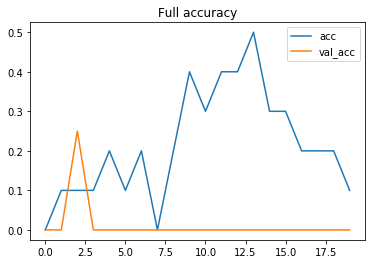

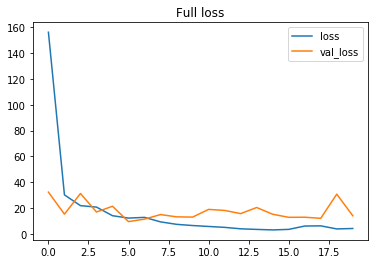

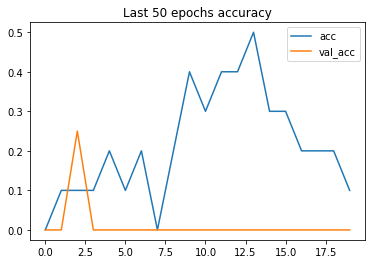

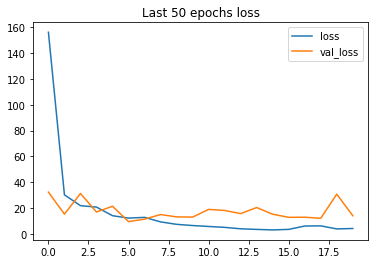

In [28]:
history_df = pd.DataFrame(
    {'acc': history.history['acc'],
     'val_acc': history.history['val_acc'],
     'loss': history.history['loss'],
     'val_loss': history.history['val_loss']
    })

print(history_df.describe())

history_df[['acc', 'val_acc']].plot(title='Full accuracy')
history_df[['loss', 'val_loss']].plot(title='Full loss')
history_df[['acc', 'val_acc']][-50:].plot(title='Last 50 epochs accuracy')
history_df[['loss', 'val_loss']][-50:].plot(title='Last 50 epochs loss')

In [29]:
best_model = keras.models.load_model(PATH_TO_BEST_MODEL)

In [30]:
best_model.evaluate(val_data, val_labels)

4/4 [==============================] - 0s 76ms/step


[9.57723331451416, 0.0]

In [33]:
print('Predicted data:')
model.predict(val_data)

Predicted data:


array([[15.769755],
       [11.882329],
       [19.056707],
       [ 8.24105 ]], dtype=float32)

In [34]:
print('Real data:')
val_labels

Real data:


array([20, 11, 14,  5])